## Sentiment Analysis on IMDB dataset

#### Sentiment Analysis on IMDB dataset using different classifiers such as LinearSVM, LogisticRegression, NaiveBayes, XGBoost, RandomForest with different kind of embeddings such as TF-IDF, USE, and TF-IDF+USE

#### Installing and importing libraries

In [1]:
pip install -U nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 245.8 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.5 MB 381.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 607.9 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.5 MB 983.9 kB/s eta 0:00:02
   --------------- ------------------------ 0.6/1.5 MB 1.7 MB/s eta 0:00:01
   ------------------------------- -------- 1.2/1.5 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
Note: you may need to restart the kernel

In [1]:
#pip install tensorflow

In [ ]:
pip install tensorflow_hub

In [2]:
#pip install torch

In [3]:
#pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [5]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\REAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\REAL\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\REAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\REAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
stop_words = set(stopwords.words('english'))

#### To check is there any GPU available or not

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. 
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU not available, CPU used


#### Load the IMDB dataset for sentiment analysis between positive and negative reviews

In [4]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.sample(frac=1).reset_index(drop=True)
df

,review,sentiment
0,Blue Monkey (1987) or 'Invasion of the BodySuc...,negative
1,We rented the DVD hoping for a good western. T...,negative
2,This pile of sh!t is tied in my book as the wo...,negative
3,One of the worst movies I ever saw. My only th...,negative
4,"Any film with a title as ridiculous as ""The Ba...",negative
...,...,...
49995,This has to be the all time best computer anim...,positive
49996,"Personally, I think Kevin Spacey is one of the...",positive
49997,This whirling movie looks more like a combinat...,negative
49998,I cannot believe it has been 25 yrs since I fi...,positive


#### Exploratory Data Analysis for IMDB dataset

In [5]:
class EDA():
    def get_length_dist(self,data):
        rev_len = [len(i) for i in data]
        pd.Series(rev_len).hist()
        plt.title('Number of types of commets')
        plt.xlabel('length')
        plt.ylabel('number')
        plt.show()
        print(pd.Series(rev_len).describe())
    def get_class_dist(self,df):
        df['sentiment'].replace({1:'positive',0:'negative'}).value_counts().plot(kind='bar',figsize=(7,4))
        plt.title('Number of types')
        plt.xlabel('Comment_type')
        plt.ylabel('number')
        plt.show()


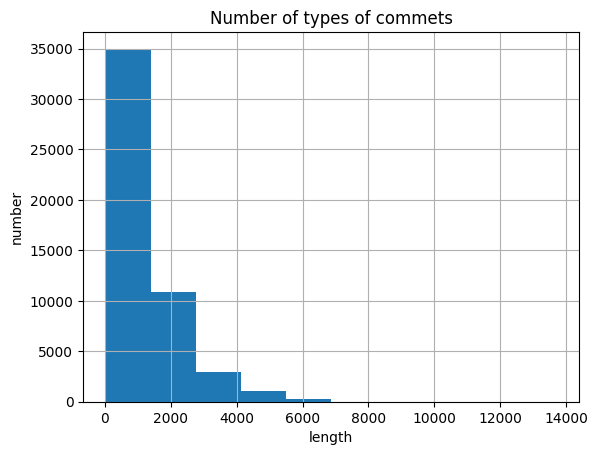

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
dtype: float64


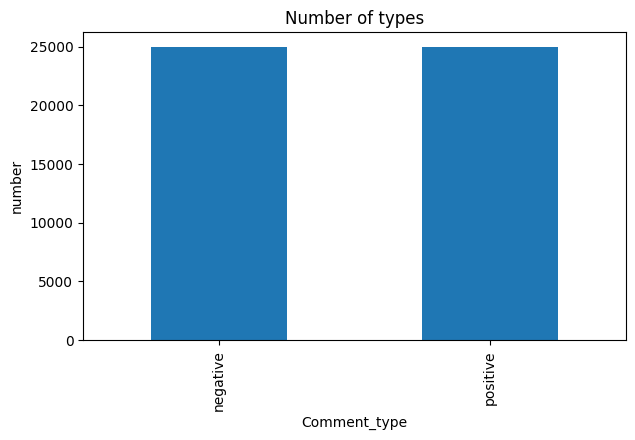

In [6]:
eda = EDA()
eda.get_length_dist(df['review'])
eda.get_class_dist(df)

#### Preprocess the data

In [7]:
def preprocess_text(text):
    # Remove HTML tags and strip whitespace
    text = re.sub(r'<[^>]*>', '', text)
    text = text.strip()
    # Remove noisy characters and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Lowercase text
    text = text.lower()
    # Tokenize text and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


In [8]:
df['review'] = df['review'].apply(preprocess_text)

In [9]:
df['review'].head(20)

0     blue monkey 1987 invasion bodysuckers known uk...
1     rented dvd hoping good western film pretty sce...
2     pile sht tied book worst thing ever made cant ...
3     one worst movies ever saw thought get money ba...
4     film title ridiculous bagman automatically att...
5     körkarlen 1921 classic film cult status amongs...
6     maybe excessive weight gain seagal put maybe h...
7     wow movie absolutely brilliant really dont kno...
8     filmatography excellent nice camera angles don...
9     one worst wastes 35mm movie film ever unleashe...
10    klutzy young man returns west schooled hotel b...
11    one finest films ever made got 76 rating myste...
12    life short waste two hours hollywood nonsense ...
13    think film educational however fails treat iss...
14    attention chuck davis emefy saw phantom lady m...
15    allocated fans winner takes match occurred two...
16    reading reviews became obvious everyone intell...
17    dont know whether film hits heart way feel

#### Split x=feature, y=target

In [10]:
x = df['review']
y = df['sentiment']

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()
Y = label_encode.fit_transform(df['sentiment'])
Y

array([0, 0, 0, ..., 0, 1, 0])

In [12]:
y

0        negative
1        negative
2        negative
3        negative
4        negative
           ...   
49995    positive
49996    positive
49997    negative
49998    positive
49999    negative
Name: sentiment, Length: 50000, dtype: object

### Note: 0 represent negative comments and 1 represent positive comments

### Split the dataset into training and testing sets


In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, Y, test_size=0.2, random_state=42)

### Create a vocabulary

In [14]:
# Create a vocabulary
from collections import Counter
word_counts = Counter(' '.join(xtrain).split())

### Display each word in the vocabulary along with its count


In [1]:
#for word, count in word_counts.items():
    #print(f"{word}: {count}")

In [2]:
#vocab = [word for word, count in word_counts.most_common()]
#vocab

### Classification with various classifiers
#### 1. Linear SVM
#### 2. Logistic Regression (LR)
#### 3. Naive Bayes
#### 4. XGBoost
#### 5. Random Forest

In [17]:
#Import libraries
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from timeit import default_timer as timer

#### Initialize classifiers

In [18]:
svm_classifier = LinearSVC()
logistic_regression = LogisticRegression(max_iter=1000)
nb_classifier = MultinomialNB()
xgboost_classifier = XGBClassifier()
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=3, max_features='sqrt', min_samples_leaf=4, bootstrap=True, n_jobs=-1, random_state=0)

In [19]:
def evaluate_model(model, xtest, ytest):
    # Make predictions using the model
    y_pred = model.predict(xtest)

    # Calculate accuracy
    accuracy = accuracy_score(ytest, y_pred)
    # Calculate precision
    precision = precision_score(ytest, y_pred)
    # Calculate recall
    recall = recall_score(ytest, y_pred)
    # Calculate f1 score
    f1 = f1_score(ytest, y_pred)
    # Generate a classification report and confusion matrix
    report = classification_report(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    return y_pred, accuracy, precision, recall, f1, report, cm


In [20]:
# Define batch size
batch_size = 1000

## 1. TF-IDF

#### TF-IDF Vectorization


In [21]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

##### Process the data in smaller batches for training data


In [22]:
start = timer()
tfidf_vectorizer_xtrain = []
for i in range(0, len(xtrain), batch_size):
    batch_X_train = xtrain[i:i + batch_size]
    batch_X_train_tfidf = tfidf_vectorizer.fit_transform(batch_X_train)
    tfidf_vectorizer_xtrain.extend(batch_X_train_tfidf.toarray())
print('Required time for embedding TFIDF with train data:- ', timer() - start) 

Required time for embedding TFIDF with train data:-  10.383901300000048


##### Repeat the same process for test data


In [23]:
start = timer()
tfidf_vectorizer_xtest = []
for i in range(0, len(xtest), batch_size):
    batch_X_test = xtest[i:i + batch_size]
    batch_X_test_tfidf = tfidf_vectorizer.transform(batch_X_test)
    tfidf_vectorizer_xtest.extend(batch_X_test_tfidf.toarray())
print('Required time for embedding TFIDF with train data:- ', timer() - start) 

Required time for embedding TFIDF with train data:-  1.926313499999992


#### Fit classifiers

In [24]:
start = timer()
svm_tfidf = svm_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Required time for training Linear SVM classifiers:- ', timer() - start) 
start = timer()
lr_tfidf = logistic_regression.fit(tfidf_vectorizer_xtrain, ytrain)
print('Required time for training Logistic Regression classifiers:- ', timer() - start) 
start = timer()
nb_tfidf = nb_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Required time for training Naive Bayes classifiers:- ', timer() - start) 
start = timer()
xgboost_tfidf = xgboost_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Required time for training XGBoost classifiers:- ', timer() - start) 
start = timer()
rfc_tfidf = random_forest_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Required time for training all five classifiers:- ', timer() - start) 

c:\users\real\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Required time for training Linear SVM classifiers:-  5.524283699999955
Required time for training Logistic Regression classifiers:-  10.336156500000016
Required time for training Naive Bayes classifiers:-  6.6202760999999555
Required time for training XGBoost classifiers:-  220.29833220000012
Required time for training all five classifiers:-  16.086862999999994


#### Make predictions

### Linear SVM

In [25]:
start = timer()
y_pred_svm, accuracy_svm, precision_svm, recall_svm, f1_svm, report_svm, confusion_matrix_svm = evaluate_model(svm_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for SVM prediction:- ', timer() - start) 

Required time for SVM prediction:-  1.2270871000000625


#### Print actual vs. predicted results for LinearSVM

In [26]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm[:15]):
    print(f"Actual: {actual}, SVM Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM Predicted: 0

Actual: 1, SVM Predicted: 1

Actual: 0, SVM Predicted: 0

Actual: 0, SVM Predicted: 1

Actual: 1, SVM Predicted: 1

Actual: 1, SVM Predicted: 1

Actual: 1, SVM Predicted: 0

Actual: 0, SVM Predicted: 1

Actual: 1, SVM Predicted: 1

Actual: 1, SVM Predicted: 0

Actual: 1, SVM Predicted: 1

Actual: 0, SVM Predicted: 0

Actual: 1, SVM Predicted: 1

Actual: 0, SVM Predicted: 0

Actual: 0, SVM Predicted: 0



In [27]:
print(f"LinearSVM Accuracy: {accuracy_svm:.2f}")
print(f"LinearSVM Precision: {precision_svm:.2f}")
print(f"LinearSVM Recall: {recall_svm:.2f}")
print(f"LinearSVM F1 score: {f1_svm:.2f}")
print("Classification Report:")
print(report_svm)
print("Confusion Matrix")
print(confusion_matrix_svm)

LinearSVM Accuracy: 0.69
LinearSVM Precision: 0.70
LinearSVM Recall: 0.68
LinearSVM F1 score: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4941
           1       0.70      0.68      0.69      5059

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Confusion Matrix
[[3473 1468]
 [1644 3415]]


### Logistic Regression

In [28]:
start = timer()
y_pred_lr, accuracy_lr, precision_lr, recall_lr, f1_lr, report_lr, cm_lr = evaluate_model(lr_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Logistic Regression prediction:- ', timer() - start) 

Required time for Logistic Regression prediction:-  0.5415533999998843


#### Print actual vs. predicted results for Logistic Regression


In [29]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr[:15]):
    print(f"Actual: {actual}, Logistic Regression Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Logistic Regression Predicted: 0

Actual: 1, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 1

Actual: 1, Logistic Regression Predicted: 1

Actual: 1, Logistic Regression Predicted: 1

Actual: 1, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 1

Actual: 1, Logistic Regression Predicted: 1

Actual: 1, Logistic Regression Predicted: 0

Actual: 1, Logistic Regression Predicted: 1

Actual: 0, Logistic Regression Predicted: 0

Actual: 1, Logistic Regression Predicted: 1

Actual: 0, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 0



In [30]:
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
print(f"Logistic Regression Precision: {precision_lr:.2f}")
print(f"Logistic Regression Recall: {recall_lr:.2f}")
print(f"Logistic Regression F1 score: {f1_lr:.2f}")
print("Classification Report:")
print(report_lr)
print("Confusion Matrix")
print(cm_lr)

Logistic Regression Accuracy: 0.70
Logistic Regression Precision: 0.71
Logistic Regression Recall: 0.67
Logistic Regression F1 score: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      4941
           1       0.71      0.67      0.69      5059

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

Confusion Matrix
[[3576 1365]
 [1660 3399]]


### Naive bayes

In [31]:
start = timer()
y_pred_nb, accuracy_nb, precision_nb, recall_nb, f1_nb, report_nb, cm_nb = evaluate_model(nb_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Naive Bayes prediction:- ', timer() - start) 

Required time for Naive Bayes prediction:-  0.5743786999998974


#### Print actual vs. predicted results for Naive bayes


In [32]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_nb[:15]):
    print(f"Actual: {actual}, Naive bayes Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 1

Actual: 1, Naive bayes Predicted: 1

Actual: 1, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 1

Actual: 0, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0



In [33]:
print(f"Naive bayes Accuracy: {accuracy_nb:.2f}")
print(f"Naive bayes Precision: {precision_nb:.2f}")
print(f"Naive bayes Recall: {recall_nb:.2f}")
print(f"Naive bayes F1 score: {f1_nb:.2f}")
print("Classification Report:")
print(report_nb)
print("Confusion Matrix:")
print(cm_nb)

Naive bayes Accuracy: 0.68
Naive bayes Precision: 0.74
Naive bayes Recall: 0.58
Naive bayes F1 score: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.71      4941
           1       0.74      0.58      0.65      5059

    accuracy                           0.68     10000
   macro avg       0.70      0.69      0.68     10000
weighted avg       0.70      0.68      0.68     10000

Confusion Matrix:
[[3938 1003]
 [2148 2911]]


### XGBoost Classifier

In [34]:
start = timer()
y_pred_xgboost, accuracy_xgboost, precision_xgboost, recall_xgboost, f1_xgboost, report_xgboost, cm_xgboost = evaluate_model(xgboost_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for XGBoost classifier prediction:- ', timer() - start) 

Required time for XGBoost classifier prediction:-  0.7785725000001094


#### Print actual vs. predicted results for XGBoost classifier


In [35]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgboost[:15]):
    print(f"Actual: {actual}, XGBoost Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 0

Actual: 0, XGBoost Predicted: 1

Actual: 0, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 1

Actual: 1, XGBoost Predicted: 1

Actual: 0, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 1

Actual: 1, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 1

Actual: 0, XGBoost Predicted: 1

Actual: 1, XGBoost Predicted: 1

Actual: 0, XGBoost Predicted: 1

Actual: 0, XGBoost Predicted: 1



In [36]:
print(f"XGBoost Accuracy: {accuracy_xgboost:.2f}")
print(f"XGBoost Precision: {precision_xgboost:.2f}")
print(f"XGBoost Recall: {recall_xgboost:.2f}")
print(f"XGBoost F1 score: {f1_xgboost:.2f}")
print("Classification Report:")
print(report_xgboost)
print("Confusion Matrix:")
print(cm_xgboost)

XGBoost Accuracy: 0.69
XGBoost Precision: 0.69
XGBoost Recall: 0.69
XGBoost F1 score: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      4941
           1       0.69      0.69      0.69      5059

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Confusion Matrix:
[[3382 1559]
 [1548 3511]]


### Random Forest Classifier

In [37]:
start = timer()
y_pred_rfc, accuracy_rfc, precision_rfc, recall_rfc, f1_rfc, report_rfc, cm_rfc = evaluate_model(rfc_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Random Forest classifier prediction:- ', timer() - start) 

Required time for Random Forest classifier prediction:-  0.4677316999998311


#### Print actual vs. predicted results for Random Forest classifier

In [38]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc[:15]):
    print(f"Actual: {actual}, Random Forest Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Random Forest Predicted: 0

Actual: 1, Random Forest Predicted: 0

Actual: 0, Random Forest Predicted: 1

Actual: 0, Random Forest Predicted: 0

Actual: 1, Random Forest Predicted: 0

Actual: 1, Random Forest Predicted: 1

Actual: 1, Random Forest Predicted: 0

Actual: 0, Random Forest Predicted: 1

Actual: 1, Random Forest Predicted: 1

Actual: 1, Random Forest Predicted: 0

Actual: 1, Random Forest Predicted: 0

Actual: 0, Random Forest Predicted: 0

Actual: 1, Random Forest Predicted: 1

Actual: 0, Random Forest Predicted: 0

Actual: 0, Random Forest Predicted: 0



In [39]:
print(f"Random Forest Accuracy: {accuracy_rfc:.2f}")
print(f"Random Forest Precision: {precision_rfc:.2f}")
print(f"Random Forest Recall: {recall_rfc:.2f}")
print(f"Random Forest F1 score: {f1_rfc:.2f}")
print("Classification Report:")
print(report_rfc)
print("Confusion Matrix:")
print(cm_rfc)

Random Forest Accuracy: 0.64
Random Forest Precision: 0.69
Random Forest Recall: 0.53
Random Forest F1 score: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.76      0.68      4941
           1       0.69      0.53      0.60      5059

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000

Confusion Matrix:
[[3732 1209]
 [2358 2701]]


#### Display all five models accuracy

In [40]:
model_names = ['LinearSVM', 'LogisticRegression', 'NaiveBayes', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm, accuracy_lr, accuracy_nb, accuracy_xgboost, accuracy_rfc]

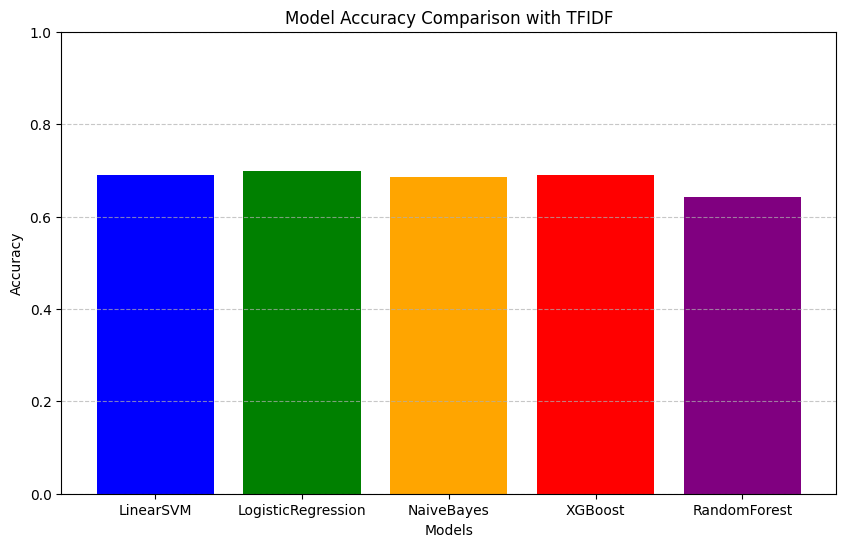

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with TFIDF")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 2. Universal Sentence Encoder (USE)
#### 1. Linear SVM
#### 2. Logistic Regression
#### 3. XGBoost classifier
#### 4. Random Forest classifier

#### Load the Universal Sentence Encoder model, and embed this model

In [42]:
start = timer()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print('Required time for upload USE from tensorflow hub:- ', timer() - start) 

Required time for upload USE from tensorflow hub:-  14.048776599999883


In [43]:
xtrain_use = []
xtest_use = []

In [44]:
start = timer()
for i in range(0, len(xtrain), batch_size):
    batch_X_train = xtrain[i:i + batch_size]
    batch_X_train_use = np.array(embed(batch_X_train))
    xtrain_use.extend(batch_X_train_use)
print('Required time for embedding xtrain with USE:- ', timer() - start) 

Required time for embedding xtrain with USE:-  57.74180700000011


In [45]:
start = timer()
for i in range(0, len(xtest), batch_size):
    batch_X_test = xtest[i:i + batch_size]
    batch_X_test_use = np.array(embed(batch_X_test))
    xtest_use.extend(batch_X_test_use)
print('Required time for embedding xtest with USE:- ', timer() - start) 

Required time for embedding xtest with USE:-  13.481257599999935


#### Fit classifiers

In [47]:
start = timer()
svm_use = svm_classifier.fit(xtrain_use, ytrain)
print('Required time for training Linear SVM classifier:- ', timer() - start) 
start = timer()
lr_use = logistic_regression.fit(xtrain_use, ytrain)
print('Required time for training Logistic Regression:- ', timer() - start)  
start = timer()
xgboost_use = xgboost_classifier.fit(xtrain_use, ytrain)
print('Required time for training XGBoost classifier:- ', timer() - start) 
start = timer()
rfc_use = random_forest_classifier.fit(xtrain_use, ytrain)
print('Required time for training all Random Forest classifier:- ', timer() - start) 

c:\users\real\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Required time for training Linear SVM classifier:-  4.793448399999988
Required time for training Logistic Regression:-  3.7724092999999357
Required time for training XGBoost classifier:-  47.12510980000002
Required time for training all Random Forest classifier:-  40.176696799999945


#### Make predictions

### Linear SVM

In [48]:
start = timer()
y_pred_svm_use, accuracy_svm_use, precision_svm_use, recall_svm_use, f1_svm_use, report_svm_use, cm_svm_use = evaluate_model(svm_use, xtest_use, ytest)
print('Required time for Linear SVM prediction with USE :- ', timer() - start) 

Required time for Linear SVM prediction with USE :-  0.17824430000018765


#### Print actual vs. predicted results for LinearSVM with USE

In [49]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm_use[:15]):
    print(f"Actual: {actual}, SVM with USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 1

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 1

Actual: 1, SVM with USE embedding Predicted: 1

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 1

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0



In [50]:
print(f"LinearSVM (USE) Accuracy: {accuracy_svm_use:.2f}")
print(f"LinearSVM (USE) Precision: {precision_svm_use:.2f}")
print(f"LinearSVM (USE) Recall: {recall_svm_use:.2f}")
print(f"LinearSVM (USE) F1 score: {f1_svm_use:.2f}")
print("Classification Report:")
print(report_svm_use)
print("Confusion Matrix")
print(cm_svm_use)

LinearSVM (USE) Accuracy: 0.84
LinearSVM (USE) Precision: 0.84
LinearSVM (USE) Recall: 0.85
LinearSVM (USE) F1 score: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4941
           1       0.84      0.85      0.84      5059

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix
[[4111  830]
 [ 771 4288]]


### Logitic Regression

In [51]:
start = timer()
y_pred_lr_use, accuracy_lr_use, precision_lr_use, recall_lr_use, f1_lr_use, report_lr_use, cm_lr_use = evaluate_model(lr_use, xtest_use, ytest)
print('Required time for LR prediction with USE :- ', timer() - start) 

Required time for LR prediction with USE :-  0.17296159999978045


#### Print actual vs. predicted results for Logistic Regression with USE

In [52]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr_use[:15]):
    print(f"Actual: {actual}, Logistic Regression Predicted with USE: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 1

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 1

Actual: 1, Logistic Regression Predicted with USE: 1

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 1

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0



In [53]:
print(f"Logistic Regression (USE) Accuracy: {accuracy_lr_use:.2f}")
print(f"Logistic Regression (USE) Precision: {precision_lr_use:.2f}")
print(f"Logistic Regression (USE) Recall: {recall_lr_use:.2f}")
print(f"Logistic Regression (USE) F1 score: {f1_lr_use:.2f}")
print("Classification Report:")
print(report_lr_use)
print("Confusion Matrix")
print(cm_lr_use)

Logistic Regression (USE) Accuracy: 0.84
Logistic Regression (USE) Precision: 0.84
Logistic Regression (USE) Recall: 0.84
Logistic Regression (USE) F1 score: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4941
           1       0.84      0.84      0.84      5059

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix
[[4125  816]
 [ 786 4273]]


### XGBoost Classifier

In [54]:
start = timer()
y_pred_xgboost_use, accuracy_xgboost_use, precision_xgboost_use, recall_xgboost_use, f1_xgboost_use, report_xgboost_use, cm_xgboost_use = evaluate_model(xgboost_use, xtest_use, ytest)
print('Required time for XGBoost classifier prediction with USE:- ', timer() - start) 

Required time for XGBoost classifier prediction with USE:-  0.274866799999927


#### Print actual vs. predicted results for XGBooost classifier with USE

In [55]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgboost_use[:15]):
    print(f"Actual: {actual}, XGBoost with USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 1

Actual: 0, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 1

Actual: 1, XGBoost with USE Predicted: 1

Actual: 0, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 1

Actual: 1, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 1

Actual: 0, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 1

Actual: 0, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0



In [56]:
print(f"XGBoost (USE) Accuracy: {accuracy_xgboost_use:.2f}")
print(f"XGBoost (USE) Precision: {precision_xgboost_use:.2f}")
print(f"XGBoost (USE) Recall: {recall_xgboost_use:.2f}")
print(f"XGBoost (USE) F1 score: {f1_xgboost_use:.2f}")
print("Classification Report:")
print(report_xgboost_use)
print("Confusion Matrix:")
print(cm_xgboost_use)

XGBoost (USE) Accuracy: 0.83
XGBoost (USE) Precision: 0.83
XGBoost (USE) Recall: 0.84
XGBoost (USE) F1 score: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4941
           1       0.83      0.84      0.83      5059

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[4060  881]
 [ 823 4236]]


### Random Forest Classifier

In [57]:
start = timer()
y_pred_rfc_use, accuracy_rfc_use, precision_rfc_use, recall_rfc_use, f1_rfc_use, report_rfc_use, cm_rfc_use = evaluate_model(rfc_use, xtest_use, ytest)
print('Required time for Random Forest classifier with USE prediction:- ', timer() - start) 

Required time for Random Forest classifier with USE prediction:-  0.27738429999999425


#### Print actual vs. predicted results for Random Forest classifier with USE

In [58]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc_use[:15]):
    print(f"Actual: {actual}, Random Forest with USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 1

Actual: 0, Random Forest with USE Predicted: 1

Actual: 0, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 1

Actual: 1, Random Forest with USE Predicted: 1

Actual: 1, Random Forest with USE Predicted: 0

Actual: 0, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 1

Actual: 1, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 0

Actual: 0, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 1

Actual: 0, Random Forest with USE Predicted: 0

Actual: 0, Random Forest with USE Predicted: 0



In [59]:
print(f"Random Forest (USE) Accuracy: {accuracy_rfc_use:.2f}")
print(f"Random Forest (USE) Precision: {precision_rfc_use:.2f}")
print(f"Random Forest (USE) Recall: {recall_rfc_use:.2f}")
print(f"Random Forest (USE) F1 score: {f1_rfc_use:.2f}")
print("Classification Report:")
print(report_rfc_use)
print("Confusion Matrix:")
print(cm_rfc_use)

Random Forest (USE) Accuracy: 0.78
Random Forest (USE) Precision: 0.79
Random Forest (USE) Recall: 0.78
Random Forest (USE) F1 score: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4941
           1       0.79      0.78      0.78      5059

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

Confusion Matrix:
[[3882 1059]
 [1113 3946]]


#### Display all four models accuracy 
##### (--Note: Naive bayes (MultinomialNB) model not used with USE embedding because it not able to resolve the issue of negative values)

In [60]:
model_names = ['LinearSVM', 'LogisticRegression', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]

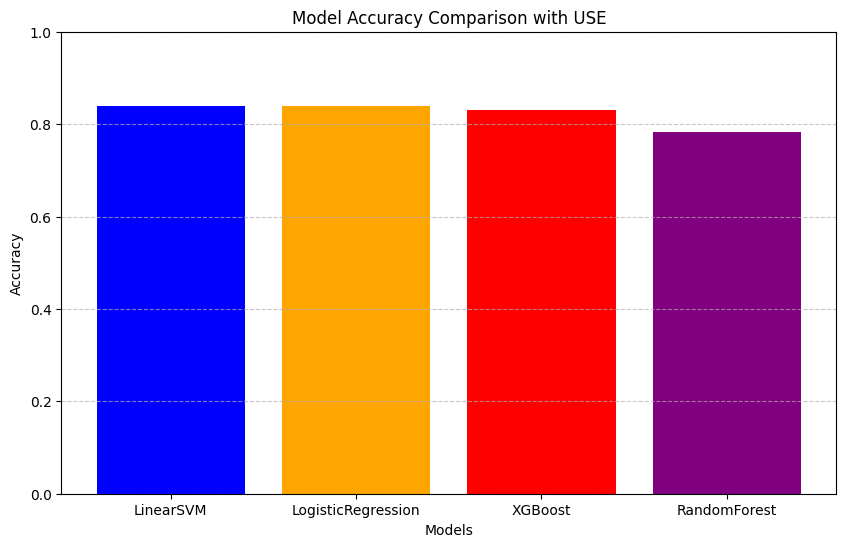

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with USE")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 3. TF-IDF + Universal Sentence Encoder (USE)
#### 1. Linear SVM
#### 2. Logistic Regression
#### 3. XGBoost classifier
#### 4. Random Forest classifier

#### Combine TF-IDF and Universal Sentence Encoder embeddings


In [62]:
xtrain_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtrain, xtrain_use], axis=1)
xtest_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtest, xtest_use], axis=1)

#### Fit classifiers

In [63]:
start = timer()
svm_tfidf_use = svm_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Linear SVM:- ', timer() - start) 
start = timer()
lr_tfidf_use = logistic_regression.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Logistic Regression:- ', timer() - start)
start = timer()
xgboost_tfidf_use = xgboost_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training XGBoost classifier:- ', timer() - start)
start = timer()
rfc_tfidf_use = random_forest_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Random Forest classifier:- ', timer() - start) 

c:\users\real\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Required time for training Linear SVM:-  7.629803400000128
Required time for training Logistic Regression:-  25.598484199999803
Required time for training XGBoost classifier:-  354.2623773
Required time for training Random Forest classifier:-  28.224720700000034


#### Make predictions

### Linear SVM

In [64]:
start = timer()
y_pred_svm_tfidf_use, accuracy_svm_tfidf_use, precision_svm_tfidf_use, recall_svm_tfidf_use, f1_svm_tfidf_use, report_svm_tfidf_use, cm_svm_tfidf_use = evaluate_model(svm_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Linear SVM prediction with TFIDF+USE :- ', timer() - start) 

Required time for Linear SVM prediction with TFIDF+USE :-  0.43146759999990536


#### Print actual vs. predicted results for Linear SVM with TFIDF + USE

In [65]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm_tfidf_use[:15]):
    print(f"Actual: {actual}, SVM with TFIDF+USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 1, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 1, SVM with TFIDF+USE Predicted: 1

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0



In [66]:
print(f"LinearSVM (TFIDF+USE) Accuracy: {accuracy_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) Precision: {precision_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) Recall: {recall_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) F1 score: {f1_svm_tfidf_use:.2f}")
print("Classification Report:")
print(report_svm_tfidf_use)
print("Confusion Matrix")
print(cm_svm_tfidf_use)

LinearSVM (TFIDF+USE) Accuracy: 0.82
LinearSVM (TFIDF+USE) Precision: 0.81
LinearSVM (TFIDF+USE) Recall: 0.83
LinearSVM (TFIDF+USE) F1 score: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4941
           1       0.81      0.83      0.82      5059

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion Matrix
[[3973  968]
 [ 863 4196]]


### Logistic Regression

In [67]:
start = timer()
y_pred_lr_tfidf_use, accuracy_lr_tfidf_use, precision_lr_tfidf_use, recall_lr_tfidf_use, f1_lr_tfidf_use, report_lr_tfidf_use, cm_lr_tfidf_use = evaluate_model(lr_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Logistic Regression prediction with TFIDF+USE :- ', timer() - start) 

Required time for Logistic Regression prediction with TFIDF+USE :-  0.2531191999996736


#### Print actual vs. predicted results for Logistic Regression with TFIDF + USE

In [68]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr_tfidf_use[:15]):
    print(f"Actual: {actual}, LR with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 1, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 1, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 1

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0



In [70]:
print(f"Logistic Regression (TFIDF+USE) Accuracy: {accuracy_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) Precision: {precision_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) Recall: {recall_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) F1 score: {f1_lr_tfidf_use:.2f}")
print("Classification Report:")
print(report_lr_tfidf_use)
print("Confusion Matrix")
print(cm_lr_tfidf_use)

Logistic Regression (TFIDF+USE) Accuracy: 0.84
Logistic Regression (TFIDF+USE) Precision: 0.83
Logistic Regression (TFIDF+USE) Recall: 0.84
Logistic Regression (TFIDF+USE) F1 score: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4941
           1       0.83      0.84      0.84      5059

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix
[[4094  847]
 [ 791 4268]]


### XGBoost Classifier

In [72]:
start = timer()
y_pred_xgb_tfidf_use, accuracy_xgb_tfidf_use, precision_xgb_tfidf_use, recall_xgb_tfidf_use, f1_xgb_tfidf_use, report_xgb_tfidf_use, cm_xgb_tfidf_use = evaluate_model(xgboost_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for XGBoost prediction with TFIDF+USE :- ', timer() - start) 

Required time for XGBoost prediction with TFIDF+USE :-  1.8905360999997356


#### Print actual vs. predicted results for XGBoost with TFIDF + USE

In [73]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgb_tfidf_use[:15]):
    print(f"Actual: {actual}, XGBoost with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 1

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 1

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 1

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0



In [75]:
print(f"XGBoost (TFIDF+USE) Accuracy: {accuracy_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) Precision: {precision_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) Recall: {recall_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) F1 score: {f1_xgb_tfidf_use:.2f}")
print("Classification Report:")
print(report_xgb_tfidf_use)
print("Confusion Matrix:")
print(cm_xgb_tfidf_use)

XGBoost (TFIDF+USE) Accuracy: 0.82
XGBoost (TFIDF+USE) Precision: 0.82
XGBoost (TFIDF+USE) Recall: 0.84
XGBoost (TFIDF+USE) F1 score: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4941
           1       0.82      0.84      0.83      5059

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion Matrix:
[[4011  930]
 [ 834 4225]]


### Random Forest classifier

In [76]:
start = timer()
y_pred_rfc_tfidf_use, accuracy_rfc_tfidf_use, precision_rfc_tfidf_use, recall_rfc_tfidf_use, f1_rfc_tfidf_use, report_rfc_tfidf_use, cm_rfc_tfidf_use = evaluate_model(rfc_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Random Forest prediction with TFIDF+USE :- ', timer() - start) 

Required time for Random Forest prediction with TFIDF+USE :-  0.45141249999960564


#### Print actual vs. predicted results for Random Forest with TFIDF + USE

In [77]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc_tfidf_use[:15]):
    print(f"Actual: {actual}, RFC with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 0, RFC with TFIDF+USE embedding Predicted: 1

Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 1, RFC with TFIDF+USE embedding Predicted: 0

Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 1, RFC with TFIDF+USE embedding Predicted: 0

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 1, RFC with TFIDF+USE embedding Predicted: 1

Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 0, RFC with TFIDF+USE embedding Predicted: 0



In [78]:
print(f"Random Forest (TFIDF+USE) Accuracy: {accuracy_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) Precision: {precision_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) Recall: {recall_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) F1 score: {f1_rfc_tfidf_use:.2f}")
print("Classification Report:")
print(report_rfc_tfidf_use)
print("Confusion Matrix:")
print(cm_rfc_tfidf_use)

Random Forest (TFIDF+USE) Accuracy: 0.79
Random Forest (TFIDF+USE) Precision: 0.78
Random Forest (TFIDF+USE) Recall: 0.80
Random Forest (TFIDF+USE) F1 score: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      4941
           1       0.78      0.80      0.79      5059

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Confusion Matrix:
[[3827 1114]
 [1013 4046]]


### Visualization

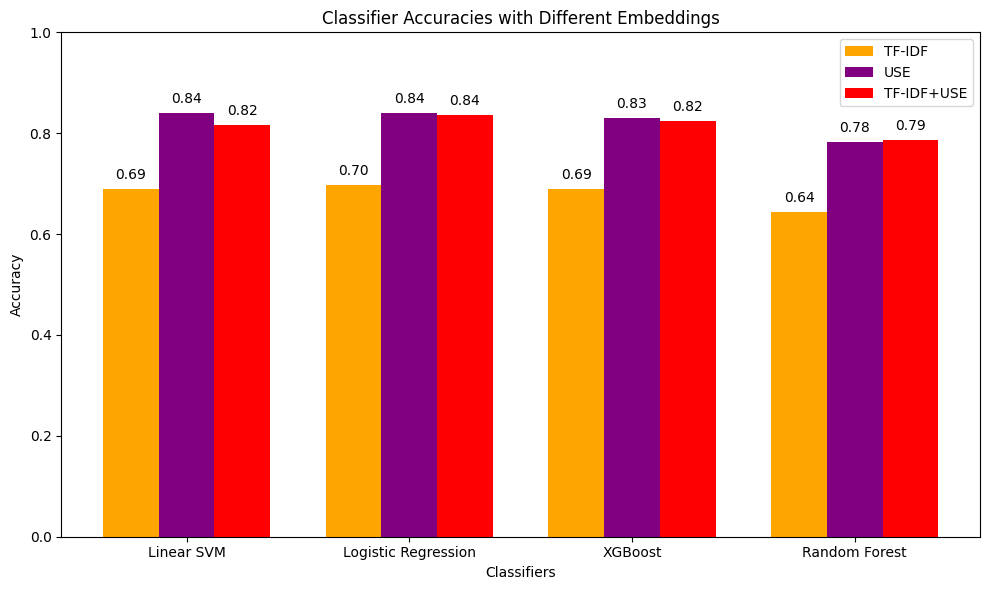

In [82]:
# Define the classifiers and their corresponding accuracies
classifiers = ["Linear SVM", "Logistic Regression", "XGBoost", "Random Forest"]
tfidf_accuracies = [accuracy_svm, accuracy_lr, accuracy_xgboost, accuracy_rfc]  # Replace with actual accuracy values
use_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]  # Replace with actual accuracy values
tfidf_use_accuracies = [accuracy_svm_tfidf_use, accuracy_lr_tfidf_use, accuracy_xgb_tfidf_use, accuracy_rfc_tfidf_use]  # Replace with actual accuracy values

# Create an index for the x-axis
x = np.arange(len(classifiers))

# Set the width of the bars
bar_width = 0.25

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, tfidf_accuracies, bar_width, label='TF-IDF', color='orange')
plt.bar(x, use_accuracies, bar_width, label='USE', color='purple')
plt.bar(x + bar_width, tfidf_use_accuracies, bar_width, label='TF-IDF+USE', color='red')

# Set labels, title, and legend
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies with Different Embeddings')
plt.xticks(x, classifiers)
plt.ylim(0, 1.0)
plt.legend()

# Add accuracy values on top of the bars
for i in range(len(classifiers)):
    plt.text(x[i] - bar_width, tfidf_accuracies[i] + 0.02, f"{tfidf_accuracies[i]:.2f}", ha='center')
    plt.text(x[i], use_accuracies[i] + 0.02, f"{use_accuracies[i]:.2f}", ha='center')
    plt.text(x[i] + bar_width, tfidf_use_accuracies[i] + 0.02, f"{tfidf_use_accuracies[i]:.2f}", ha='center')


# Display the plot
plt.tight_layout()
plt.show()


#### Conclusion: If you see above visualization, as compared to TF-IDF embedding, USE as well as TF-IDF+USE embeddings works better for sentiment analysis on IMDB dataset with different classifiers